In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../helper_functions')
sys.path.append('../objects')
sys.path.append('../../machineLearning/helpers/')
sys.path.append('/home/ssd2tb/dturcu/electric_fish_processed_data/')

import copy
import time
import dill
import numpy as np
import pandas as pd
import h5py
import scipy.io as io
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from tabulate import tabulate
import random
import seaborn as sns

In [3]:
from prefixes import remove_prefix, add_prefix
from conversions import rho24sig, convert2mainSI

from ElectricObject import ElectricObject

from Worm import Worm
from Worm_SmallSpherical import SmallSphericalWorm

from Fish import Fish
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from Boundaries import *
from Aquarium import Aquarium
from Aquarium_SinglePlane import SinglePlaneAquarium

from load_data import load_data_full

from assertion_tests import run_tests

from find_EI_ids import find_EI_ids, find_base_ids
run_tests()

'Success!'

## Load the processed data

In [4]:
file_name = '../data/processed/data_240311_falloff_with_distance_and_radius'
use_torch = False
find_base_id_for_each_EI=False

[properties_dict,
properties_ids_base, properties_ids_pert,
base_EI, base_LEODs, pert_EI, pert_LEODs,
# aquarium properties
water_conductivities, boundary_normals, boundary_displacements,
# fish properties
tail_lateral_angle, tail_dor_ven_angle, tail_location_percent, fish_yaw, fish_pitch, fish_roll,
# worm properties
resistances, capacitances, worm_radii, worm_xs, worm_ys, worm_zs,
# statistics of receptor responses
receptors_avg, receptors_std,
# objects used in simulations
aqua_objs, fish_objs, worm_objs] = \
    load_data_full(file_name=file_name, use_torch=use_torch, find_base_id_for_each_EI=find_base_id_for_each_EI)
    
print(properties_ids_base.shape)
print(properties_ids_pert.shape)

Data loaded.
Data extracted.
     Component 0: water conductivity
     Component 1: boundary normals
     Component 2: boundary displacements
     Component 3: tail lateral angle
     Component 4: tail dor ven angle
     Component 5: tail location percent
     Component 6: fish yaw
     Component 7: fish pitch
     Component 8: fish roll
     Component 9: resistances
     Component 10: capacitances
     Component 11: worm radii
     Component 12: worm xs
     Component 13: worm ys
     Component 14: worm zs
     Component 15: pert EI
     Component 16: base EI
(1, 10)
(2292, 17)


In [5]:
data_df = pd.DataFrame.from_dict(dict(
    resistance=[None],
    radius=[None],
    Distance=[None],
    MZ=[base_EI[0,0,0]],
    DLZ=[base_EI[0,0,1]]
))

In [6]:
for i in range(properties_ids_pert.shape[0]):
    data_df = pd.concat([
        data_df,
        pd.DataFrame.from_dict(dict(
            resistance=[resistances[properties_ids_pert[i, properties_dict['resistances']]].astype(float)],
            radius=[worm_radii[properties_ids_pert[i, properties_dict['worm_radii']]]*1e3],
            Distance=[worm_ys[properties_ids_pert[i, properties_dict['worm_ys']]]*1e3 - fish_objs[0].lat_ax*1e3],
            MZ=[pert_EI[i, 0, 0]],
            DLZ=[pert_EI[i, 0, 1]]
        ))
    ], ignore_index=True)

In [11]:
data_df['MZ_mod_percent'] = np.abs((data_df.MZ / data_df.MZ[0] - 1)*100)
data_df['DLZ_mod_percent'] = (data_df.DLZ / data_df.DLZ[0] - 1)*100
data_df['ObjectType'] = ['Plastic' if x > 5000 else 'Metal' for x in data_df['resistance']]
data_df['ObjectDiameter(mm)'] = np.round(2 * data_df.radius, 0)

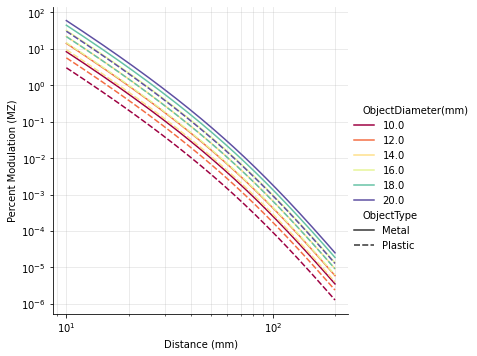

In [12]:
sns.relplot(
    data=data_df, kind="line",
    x="Distance", y="MZ_mod_percent", style="ObjectType", hue="ObjectDiameter(mm)",
    palette='Spectral'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance (mm)')
plt.ylabel('Percent Modulation (MZ)')
plt.yticks([1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6])
plt.grid(which='both',alpha=0.3)
plt.show()

In [13]:
xs = np.log(data_df['Distance'][1:])
ys = np.log(data_df['MZ_mod_percent'][1:])
np.polyfit(xs, ys, 1)

array([-5.16564627, 15.94538369])